<a href="https://colab.research.google.com/github/Rbeautelus1/Rbeautelus1/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#Import required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf

#Libraies to clean the data
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from keras.models import load_model

#library for data Visualization
import wordcloud
import matplotlib.pyplot as plt

#library and function for tokanization and vectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Importing libraries to build our models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1. Corpus

In [67]:
#The file we used as our corpus to include the customer review tsv file
file_path = '/content/customer_review.tsv'
data = pd.read_csv(file_path, delimiter='\t')


In [68]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [69]:
#printing the first 10 rows of the tables
for verified_reviews in data['verified_reviews'].iloc[0:20]:
    print("\n", verified_reviews)


 Love my Echo!

 Loved it!

 Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.

 I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.

 Music

 I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.

 Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet.

 I think this is the 5th one I've purchased. I'

2. Cleaning and Segmentation

In [70]:
#Turn all Uppercase words into lowercase and remove special characters and digits.

#1. Turn all Uppercase and Captilized words into lowercase
data['verified_reviews'] = data['verified_reviews'].astype(str)
data['verified_reviews'] = data['verified_reviews'].apply(lambda word:' '.join(word.lower() for word in word.split()))

#2. remove any digits/numbers and special character
data['verified_reviews'] = data['verified_reviews'].str.replace('\d+', ' ',regex = True)

#3. Remove any special characters
data['verified_reviews'] = data['verified_reviews'].str.replace('\W', ' ',regex = True)

#print the dataset after the cleaning
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
1,5,31-Jul-18,Charcoal Fabric,loved it,1
2,4,31-Jul-18,Walnut Finish,sometimes while playing a game you can answer...,1
3,5,31-Jul-18,Charcoal Fabric,i have had a lot of fun with this thing my ...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


In [71]:
#Remove StopWords: To remove stopword you use the Library nltk, in particular you will need to import nltk.corpus.

stopwords_list = set(stopwords.words('english'))
data['verified_reviews'] = data['verified_reviews'].apply(lambda word: ' '.join([word for word in word.split() if word not in stopwords_list]))

#printing dataset
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love echo,1
1,5,31-Jul-18,Charcoal Fabric,loved,1
2,4,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1
3,5,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs control ...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


In [72]:
#Printing first 10 reviews of our dataset

for verified_reviews in data['verified_reviews'].iloc[0:15]:
    print("\n",verified_reviews)


 love echo

 loved

 sometimes playing game answer question correctly alexa says got wrong answers like able turn lights away home

 lot fun thing yr old learns dinosaurs control lights play games like categories nice sound playing music well

 music

 received echo gift needed another bluetooth something play music easily accessible found smart speaker wait see else

 without cellphone cannot use many features ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random questions hear response seem smartbon politics yet

 think th one purchased working getting one every room house really like features offer specifily playing music echos controlling lights throughout house

 looks great

 love listened songs heard since childhood get news weather information great

 sent year old dad talks constantly

 love learning knew things eveyday still figuring everything works far easy use understand make laugh times

 purchased mother knee problems 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



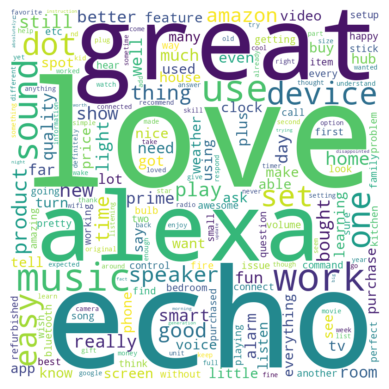

In [73]:
#Create a cloud of words upon their frequency: We will use two library
common_words = " "

for i in data.verified_reviews:
    i = str(i)
    word = i.split()
    common_words += " ".join(word)+" "
    print(common_words)

wordcloud = wordcloud.WordCloud(width = 800, height = 800,background_color='white', min_font_size=10, collocations=False).generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

3-4. Tokenization and Vectorization

In [74]:
#Let breakdown each news into words: We will need to import Tokanizer library and keras.
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)


#print the news tokes-vectors.
print("number of rows:{}\nnumber of columns: {}".format(len(X),len(X[0])))
X[0:5]

number of rows:3150
number of columns: 2


[[1, 2],
 [172],
 [181, 99, 229, 468, 4, 287, 42, 469, 379, 6, 57, 68, 62, 252, 20],
 [89, 36, 45, 136, 94, 62, 21, 253, 6, 66, 11, 99, 5, 34],
 [5]]

In [75]:
X = pad_sequences(X)

print("number of rows:{}\nnumber of columns: {}".format(len(X),len(X[0])))
X[0:5]

number of rows:3150
number of columns: 165


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

5-6. Embedding and Building our Model


In [76]:
# Defining a new variable to store the sentiment [labels]
Y = data['feedback']

#Using LabelEncoding:this method will turn the sentiment values into numerical values [encode strings values into numerical values]
Y = LabelEncoder().fit_transform(Y)

#Turning labels into categorical values.
Y = to_categorical(Y)

In [77]:
Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [78]:
#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20)
print("Number of samples for training [reviews]:{}\nNumber of sample for training [Labels]:{}".format(X_train.shape,y_train.shape))
print("Number of samples for testing [reviews]:{}\nNumber of sample for testing [Labels]:{}".format(X_test.shape,y_test.shape))

Number of samples for training [reviews]:(2520, 165)
Number of sample for training [Labels]:(2520, 2)
Number of samples for testing [reviews]:(630, 165)
Number of sample for testing [Labels]:(630, 2)


In [79]:
#define model
n_features = 31
from keras.models import Sequential
# Define the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=500, output_dim=120, input_length=X.shape[1]))

# SpatialDropout1D layer
model.add(SpatialDropout1D(0.4))

# LSTM layer
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))

# Dense layer
model.add(Dense(2, activation='softmax'))

model.summary()





Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 165, 120)          60000     
                                                                 
 spatial_dropout1d_5 (Spati  (None, 165, 120)          0         
 alDropout1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 176)               209088    
                                                                 
 dense_5 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269442 (1.03 MB)
Trainable params: 269442 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
# compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(X_train,y_train, epochs=5, batch_size=32, verbose='auto')

model.save('sequential_3')



Epoch 1/5
79/79 [==============================] - 55s 655ms/step - loss: 0.3161 - accuracy: 0.9056
Epoch 2/5
79/79 [==============================] - 51s 645ms/step - loss: 0.2197 - accuracy: 0.9198
Epoch 3/5
79/79 [==============================] - 51s 637ms/step - loss: 0.1614 - accuracy: 0.9353
Epoch 4/5
79/79 [==============================] - 52s 655ms/step - loss: 0.1263 - accuracy: 0.9496
Epoch 5/5
79/79 [==============================] - 50s 633ms/step - loss: 0.1002 - accuracy: 0.9627


In [81]:
# Evaluate out model using the accuracy metric
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.927


In [82]:
# Evaluating the model
sentiment_prediction = model.predict(X_test)
predicted_inverse = np.argmax(sentiment_prediction,axis=1)
y_test_inverse = np.argmax(y_test,axis=1)

20/20 [==============================] - 2s 81ms/step


In [83]:
target_name = ["Class {}".format(i) for i in range(2)]

print(classification_report(y_test_inverse,predicted_inverse,target_names=target_name))

              precision    recall  f1-score   support

     Class 0       0.40      0.36      0.38        39
     Class 1       0.96      0.96      0.96       591

    accuracy                           0.93       630
   macro avg       0.68      0.66      0.67       630
weighted avg       0.92      0.93      0.93       630



In [84]:
from keras.models import load_model


model = load_model('sequential_3')

def preprocess_review(review):
    # Download NLTK stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    # Tokenize and remove stopwords
    tokenizer = Tokenizer()
    review_words = [word.lower() for word in nltk.word_tokenize(review) if word.isalpha() and word.lower() not in stop_words]

    # Fit tokenizer on the review
    tokenizer.fit_on_texts(review_words)

    # Convert review words to sequences
    review_sequences = tokenizer.texts_to_sequences([review_words])

    # Pad sequences to a fixed length (assuming X.shape[1] is the length of input sequences)
    padded_review = pad_sequences(review_sequences, maxlen=X.shape[1])

    return padded_review

# Get user input for the product review
user_review = input("Enter your product review: ")

# Preprocess the user's review
preprocessed_review = preprocess_review(user_review)

# Make predictions using the trained model
predicted_sentiment = model.predict(preprocessed_review)

#predictions_normalized = verified_reviews(model, preprocessed_review)

# Convert the predicted sentiment to a readable format (assuming two classes)
predicted_label = np.argmax(predicted_sentiment)

# Print the predicted sentiment
if predicted_label == 0:
    print("Predicted sentiment: Negative")
else:
  print("Predicted sentiment: Positive")








Enter your product review: Super easy set up and am loving our new Echo!	1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 0s 473ms/step
Predicted sentiment: Positive
